In [ ]:
import io
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
import numpy as np
from sklearn import preprocessing

In [ ]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### 1) Création de la table maitre.

In [ ]:
# Lecture des fichiers csv
df_timeSpaceFrame    = pd.read_csv('/content/drive/My Drive/Data/YCBS-299/time_space_frame.csv')
df_frEvents          = pd.read_csv('/content/drive/My Drive/Data/YCBS-299/FR_Events.csv')
df_socialHousing     = pd.read_csv('/content/drive/My Drive/Data/YCBS-299/social_housing.csv')
df_weatherdata       = pd.read_csv('/content/drive/My Drive/Data/YCBS-299/Weather_data_2015_2019.csv')
df_Holiday           = pd.read_csv('/content/drive/My Drive/Data/YCBS-299/Holiday_2015_2019.csv')
df_Demog             = pd.read_csv('/content/drive/My Drive/Data/YCBS-299/demographics_final.csv')

col_to_prep = ['Sum_age_0_14', 'Sum_age_15_64', 'Sum_age_65', 'Sum_Income_10k', 'Sum_Income_20k', 'Sum_Income_30k', 
               'Sum_Income_40k', 'Sum_Income_50k', 'Sum_Income_60k', 'Sum_Income_70k', 'Sum_Income_80k', 'Sum_Income_90k', 
               'Sum_Income_100k']
for col in col_to_prep:
  df_Demog[col] = df_Demog[col]/df_Demog['Sum_Pop_total']

# On retravaille un peu le format de dates
df_timeSpaceFrame['DateFMT'] = pd.to_datetime(df_timeSpaceFrame['Date'])
df_frEvents['DateFMT'] = pd.to_datetime(df_frEvents['Date'])
df_frEvents['Shift'] = df_frEvents['Shift'].apply(lambda x: 'Night' if x==1 else 'Day' if  x==2 else 'Evening')
df_frEvents['Station'] = df_frEvents['Caserne'].astype('int32')
df_weatherdata['DateFMT'] = pd.to_datetime(df_weatherdata['Date'])
df_Holiday['DateFMT'] = pd.to_datetime(df_Holiday['Date'])

In [ ]:
# Jointure des tables
df_tmp1 = pd.merge(df_timeSpaceFrame, df_frEvents,  how='left', left_on=['DateFMT','Shift', 'Station'], right_on = ['DateFMT','Shift','Station'])
df_tmp2 = pd.merge(df_tmp1, df_socialHousing,  how='left', left_on=['Station'], right_on = ['Station'])
df_tmp3 = pd.merge(df_tmp2, df_weatherdata,  how='left', left_on=['DateFMT','Shift'], right_on = ['DateFMT','Shift'])
df_tmp3 = pd.merge(df_tmp3, df_Holiday,  how='left', left_on=['DateFMT'], right_on = ['DateFMT'])
df_tmp3 = pd.merge(df_tmp3, df_Demog,  how='left', left_on=['Station'], right_on = ['NO_CAS_ADM'])
df_tmp3 = df_tmp3.fillna(0)
df_tmp3=df_tmp3.sort_values(by=['DateFMT','Shift','Station'])
df_tmp3['WeekDay'] = df_tmp3['DateFMT'].dt.dayofweek
df_tmp3["Month"]   = df_tmp3['DateFMT'].dt.month
df_clean = df_tmp3[['DateFMT','Station','Shift','COOP_sum','HLM_sum','OBNL_sum','OMHM_sum','SHDM_sum','WeekDay','Month','Temp_DC_Mean', 'Humid_percent_Mean', 
                    'Win_Dir_Mean', 'Wind_Speed_Mean', 'Stn_Press_Mean', 'Temp_DC_Max', 'Humid_percent_Max', 'Win_Dir_Max', 'Wind_Speed_Max', 'Stn_Press_Max', 
                    'Temp_DC_Min', 'Humid_percent_Min', 'Win_Dir_Min', 'Wind_Speed_Min', 'Stn_Press_Min', 'Holiday', 'Sum_age_0_14', 'Sum_age_15_64', 
                    'Sum_age_65', 'Sum_Income_10k', 'Sum_Income_20k', 'Sum_Income_30k', 'Sum_Income_40k', 'Sum_Income_50k', 'Sum_Income_60k', 
                    'Sum_Income_70k', 'Sum_Income_80k', 'Sum_Income_90k','Sum_Income_100k', 'Target']]
df_clean = df_clean.set_index('DateFMT')
df_clean.head()

,Station,Shift,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,WeekDay,Month,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Holiday,Sum_age_0_14,Sum_age_15_64,Sum_age_65,Sum_Income_10k,Sum_Income_20k,Sum_Income_30k,Sum_Income_40k,Sum_Income_50k,Sum_Income_60k,Sum_Income_70k,Sum_Income_80k,Sum_Income_90k,Sum_Income_100k,Target
DateFMT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,3,Day,634.0,876.0,283.0,26.0,29.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.118366,0.777388,0.104530,0.138173,0.087377,0.067002,0.067381,0.055629,0.050322,0.042077,0.033453,0.028525,0.108795,0.0
2015-01-01,4,Day,298.0,454.0,1189.0,67.0,384.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.168830,0.685857,0.145313,0.162507,0.133444,0.093123,0.063672,0.041043,0.028841,0.022352,0.015585,0.011481,0.051359,4.0
2015-01-01,5,Day,133.0,1112.0,186.0,0.0,64.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.063436,0.785372,0.151131,0.178847,0.106617,0.082115,0.066590,0.052095,0.038874,0.031536,0.021833,0.015162,0.058403,4.0
2015-01-01,8,Day,0.0,0.0,0.0,0.0,0.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.145754,0.674081,0.180296,0.159187,0.133019,0.121244,0.099874,0.071438,0.044354,0.028654,0.017925,0.009900,0.018230,0.0
2015-01-01,9,Day,327.0,881.0,305.0,0.0,135.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.211042,0.654038,0.134761,0.205352,0.154467,0.102501,0.065982,0.034930,0.017989,0.010361,0.006261,0.002956,0.004831,4.0


#### 2) Création des features.

In [ ]:
def create_lag(df, p, sortList, partList, lagList):
    """
    Cette fonction prend comme intrant un df, une liste de variables pour lesquelles il faut
    creer des valeurs retardees, le nombre de retard, les variables sur lesquelles il faut sort,
    les variables de partition et la liste de varibles pour lesquelles on veut des valeurs retardees.
    La fonction retourne un df augmente des variables retardees
    """
    df = df.sort_values(by=sortList)
    
    for feature in lagList:
        for i in range(p):
            df['{}.L{}'.format(feature,i+1)] = df.groupby(partList)[feature].shift(i+1)
    
    return df

In [ ]:
mean = df_clean[['Station','Target']].groupby(['Station']).mean()
median = df_clean[['Station','Target']].groupby(['Station']).median()

mean = mean.rename(columns={'Target': 'Target_mean'})
median = median.rename(columns={'Target': 'Target_median'})

total = mean.join(median)
total = total.reset_index()
df_clean = df_clean.reset_index()
df_clean = pd.merge(df_clean, total,  how='left', left_on=['Station'], right_on = ['Station'])
df_clean = df_clean.set_index('DateFMT')
df_clean.head()

,Station,Shift,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,WeekDay,Month,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Holiday,Sum_age_0_14,Sum_age_15_64,Sum_age_65,Sum_Income_10k,Sum_Income_20k,Sum_Income_30k,Sum_Income_40k,Sum_Income_50k,Sum_Income_60k,Sum_Income_70k,Sum_Income_80k,Sum_Income_90k,Sum_Income_100k,Target,Target_mean,Target_median
DateFMT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,3,Day,634.0,876.0,283.0,26.0,29.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.118366,0.777388,0.104530,0.138173,0.087377,0.067002,0.067381,0.055629,0.050322,0.042077,0.033453,0.028525,0.108795,0.0,0.403797,0.0
2015-01-01,4,Day,298.0,454.0,1189.0,67.0,384.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.168830,0.685857,0.145313,0.162507,0.133444,0.093123,0.063672,0.041043,0.028841,0.022352,0.015585,0.011481,0.051359,4.0,1.189485,1.0
2015-01-01,5,Day,133.0,1112.0,186.0,0.0,64.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.063436,0.785372,0.151131,0.178847,0.106617,0.082115,0.066590,0.052095,0.038874,0.031536,0.021833,0.015162,0.058403,4.0,1.916210,2.0
2015-01-01,8,Day,0.0,0.0,0.0,0.0,0.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.145754,0.674081,0.180296,0.159187,0.133019,0.121244,0.099874,0.071438,0.044354,0.028654,0.017925,0.009900,0.018230,0.0,0.286783,0.0
2015-01-01,9,Day,327.0,881.0,305.0,0.0,135.0,3,1,-4.1375,71.875,22.625,27.625,100.37,-3.3,84.0,23.0,33.0,100.58,-5.7,59.0,22.0,24.0,100.18,0.0,0.211042,0.654038,0.134761,0.205352,0.154467,0.102501,0.065982,0.034930,0.017989,0.010361,0.006261,0.002956,0.004831,4.0,2.131800,2.0


In [ ]:
#Faire les list:
vars_to_lag = ['Target']

df_eng = create_lag(df=df_clean, 
                    p=7,
                    sortList=['DateFMT','Shift','Station'],
                    partList=['Shift','Station'],
                    lagList=vars_to_lag)

#Separation des features
y = df_eng[['Target']]
X_cont = df_eng[['COOP_sum', 'HLM_sum', 'OBNL_sum','OMHM_sum', 'SHDM_sum','Target.L1',
                'Target.L2', 'Target.L3', 'Target.L4', 'Target.L5', 'Target.L6', 'Target.L7',
                 'Temp_DC_Mean', 'Humid_percent_Mean', 'Win_Dir_Mean', 'Wind_Speed_Mean', 
                 'Stn_Press_Mean', 'Temp_DC_Max', 'Humid_percent_Max', 'Win_Dir_Max', 'Wind_Speed_Max', 
                 'Stn_Press_Max', 'Temp_DC_Min', 'Humid_percent_Min', 'Win_Dir_Min', 'Wind_Speed_Min', 
                 'Stn_Press_Min', 'Target_mean', 'Target_median','Sum_age_0_14', 'Sum_age_15_64', 
                 'Sum_age_65', 'Sum_Income_10k', 'Sum_Income_20k', 'Sum_Income_30k', 'Sum_Income_40k', 
                 'Sum_Income_50k', 'Sum_Income_60k', 'Sum_Income_70k', 'Sum_Income_80k', 
                 'Sum_Income_90k','Sum_Income_100k']]
X_cat = df_eng[['Shift','WeekDay', 'Month', 'Holiday']]

In [ ]:
#scaler = preprocessing.StandardScaler().fit(X_cont)
#X_cont_scaled = scaler.fit_transform(X_cont.values)
#X_cont = pd.DataFrame(X_cont_scaled, index=X_cont.index, columns=X_cont.columns)

In [ ]:
X = X_cont
for col in X_cat.columns:
  datas = pd.get_dummies(X_cat[col], prefix=col, prefix_sep='_')
  X     = pd.concat([X, datas], axis=1)
X = X.dropna()

In [ ]:
X = X.drop(['Holiday_0.0', 'WeekDay_0', 'Shift_Day'], axis=1)
X.head()

,COOP_sum,HLM_sum,OBNL_sum,OMHM_sum,SHDM_sum,Target.L1,Target.L2,Target.L3,Target.L4,Target.L5,Target.L6,Target.L7,Temp_DC_Mean,Humid_percent_Mean,Win_Dir_Mean,Wind_Speed_Mean,Stn_Press_Mean,Temp_DC_Max,Humid_percent_Max,Win_Dir_Max,Wind_Speed_Max,Stn_Press_Max,Temp_DC_Min,Humid_percent_Min,Win_Dir_Min,Wind_Speed_Min,Stn_Press_Min,Target_mean,Target_median,Sum_age_0_14,Sum_age_15_64,Sum_age_65,Sum_Income_10k,Sum_Income_20k,Sum_Income_30k,Sum_Income_40k,Sum_Income_50k,Sum_Income_60k,Sum_Income_70k,Sum_Income_80k,Sum_Income_90k,Sum_Income_100k,Shift_Evening,Shift_Night,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Holiday_1.0
DateFMT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-08,634.0,876.0,283.0,26.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-19.6125,72.375,19.375,9.625,101.67125,-15.8,79.0,24.0,18.0,101.9,-23.1,64.0,13.0,5.0,101.39,0.403797,0.0,0.118366,0.777388,0.104530,0.138173,0.087377,0.067002,0.067381,0.055629,0.050322,0.042077,0.033453,0.028525,0.108795,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-08,298.0,454.0,1189.0,67.0,384.0,0.0,1.0,0.0,1.0,2.0,2.0,4.0,-19.6125,72.375,19.375,9.625,101.67125,-15.8,79.0,24.0,18.0,101.9,-23.1,64.0,13.0,5.0,101.39,1.189485,1.0,0.168830,0.685857,0.145313,0.162507,0.133444,0.093123,0.063672,0.041043,0.028841,0.022352,0.015585,0.011481,0.051359,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-08,133.0,1112.0,186.0,0.0,64.0,2.0,1.0,1.0,2.0,2.0,1.0,4.0,-19.6125,72.375,19.375,9.625,101.67125,-15.8,79.0,24.0,18.0,101.9,-23.1,64.0,13.0,5.0,101.39,1.916210,2.0,0.063436,0.785372,0.151131,0.178847,0.106617,0.082115,0.066590,0.052095,0.038874,0.031536,0.021833,0.015162,0.058403,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-08,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,-19.6125,72.375,19.375,9.625,101.67125,-15.8,79.0,24.0,18.0,101.9,-23.1,64.0,13.0,5.0,101.39,0.286783,0.0,0.145754,0.674081,0.180296,0.159187,0.133019,0.121244,0.099874,0.071438,0.044354,0.028654,0.017925,0.009900,0.018230,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-08,327.0,881.0,305.0,0.0,135.0,7.0,2.0,5.0,1.0,1.0,2.0,4.0,-19.6125,72.375,19.375,9.625,101.67125,-15.8,79.0,24.0,18.0,101.9,-23.1,64.0,13.0,5.0,101.39,2.131800,2.0,0.211042,0.654038,0.134761,0.205352,0.154467,0.102501,0.065982,0.034930,0.017989,0.010361,0.006261,0.002956,0.004831,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### 3) Train, test, and valid split.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Validation set will be 2019 data
#X_valid, y_valid = X.loc['2019-01-01':'2019-12-31'], y.loc['2019-01-01':'2019-12-31']
#X_ts, y_ts = X.loc['2015-01-08':'2018-12-31'].reset_index(), y.loc['2015-01-08':'2018-12-31'].reset_index()

# TimeSeriesSplit for <cross-validation> like method used for TS
#tscv = TimeSeriesSplit()
#for train_index, test_index in tscv.split(X_ts):
#  print("TRAIN:", train_index, "TEST:", test_index)
#  X_train, X_test = X_ts[train_index], X_ts[test_index]
#  y_train, y_test = y_ts[train_index], y_ts[test_index]

In [ ]:
# Validation set will be 2019 data
X_valid = X.loc['2019-01-01':'2019-12-31']
y_valid = y.loc['2019-01-01':'2019-12-31']

# Train/test split using data from 2015 to 2018
X_train, X_test, y_train, y_test = train_test_split(X.loc['2015-01-08':'2018-12-31'], y.loc['2015-01-08':'2018-12-31'], test_size=0.33, random_state=42)

print('Valid X y : ', len(X_valid), '--', len(y_valid))
print('Train X y : ', len(X_train), '--', len(y_train))
print('Test X y: '  , len(X_test), '--', len(y_test))

Valid X y :  72270 -- 72270
Train X y :  192887 -- 192887
Test X y:  95005 -- 95005


#### 4) Modelling.

In [ ]:
params = {'n_estimators': 600,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'lad'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='lad',
                          max_depth=5, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=600,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# The baseline is the number of events one week before the actual prediction (same shift and station) 
bl = X_test[['Target.L7']]

In [ ]:
mpd_model = float("NaN") #mean_poisson_deviance(y_test, reg.predict(X_test))
mae_model = mean_absolute_error(y_test, reg.predict(X_test))

mpd_model_train = float("NaN") #mean_poisson_deviance(y_test, reg.predict(X_train))
mae_model_train = mean_absolute_error(y_train, reg.predict(X_train))

mpd_bl = float("NaN") # mean_poisson_deviance(y_test, bl) predicted value needs to be greater than 0
mae_bl = mean_absolute_error(y_test, bl)

print("MODEL    : The mean Poisson Deviance (P) on train set: {:.4f}".format(mpd_model_train), "The mean absolute error on train set: {:.4f}".format(mae_model_train))
print("MODEL    : The mean Poisson Deviance (P) on test set: {:.4f}".format(mpd_model), "The mean absolute error on test set: {:.4f}".format(mae_model))
print("BASELINE : The mean Poisson Deviance (P) on test set: {:.4f}".format(mpd_bl), "The mean absolute error on test set: {:.4f}".format(mae_bl))

MODEL    : The mean Poisson Deviance (P) on train set: nan The mean absolute error on train set: 0.7655
MODEL    : The mean Poisson Deviance (P) on test set: nan The mean absolute error on test set: 0.7611
BASELINE : The mean Poisson Deviance (P) on test set: nan The mean absolute error on test set: 1.0425


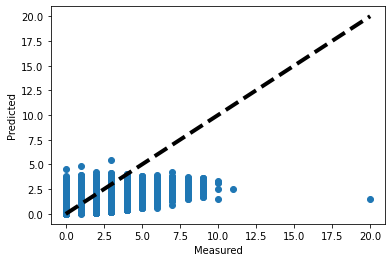

In [ ]:

pred = reg.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Text(0.5, 1.0, 'Feature Importance')

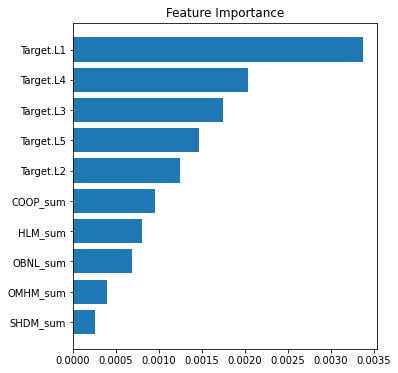

In [ ]:
feature_importance = reg.feature_importances_[0:10]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')